In [1]:
import pandas as pd
import csv
import re
import json
from tqdm import tqdm  
import time 
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import math

In [2]:
df=pd.read_csv(r'C:\Users\Windows\Desktop\Spotify_Dataset_V3.csv',delimiter=';')
df_noURL=df.iloc[:,0:-1]
url=df.iloc[:,-1]

Using the mean daily data of each features as primary data source and predict targets.
The goal is to :
1. Find a model that can fit the daily data--so we can have a better understand of the pattern
2. Try to predict the futture trends of each feature
which can be applied to the Q2 and Q4
The first algorithm is a algorithm based one called 'Holt-winters'
which is an optimised Moving Average Algorithm with better season fitting quality(which is important in this task, since we can see a weekly pattern in the daily data)

In [ ]:
# Creat a daily average data of each feature
df_nodup = df_noURL.loc[:,['Title','Artists','Date','Danceability','Energy','Loudness','Speechiness','Acousticness','Instrumentalness','Valence']]
df_nodup = df_nodup.drop_duplicates(subset=['Title','Artists','Date'])
df_nodup = df_nodup.drop('Artists', axis=1)
df_nodup = df_nodup.iloc[::-1]
Date = [];Mean_dance=[];Mean_energy=[];Mean_loud=[];Mean_speech=[];Mean_acoustic=[];Mean_instru=[];Mean_valence=[]
Var_dance=[];Var_energy=[];Var_loud=[];Var_speech=[];Var_acoustic=[];Var_instru=[];Var_valence=[]
i=199;k=0
while (df_nodup.shape[0]-i)> 0:
    date=datetime.strptime(df_nodup.iloc[i,1],'%d/%m/%Y').strftime('%Y-%m-%d')
    if i>200:
        if date == Date[-1]:
            k=k+1
            i=i+1
            continue
    Date.append(date)
    df_mean=df_nodup.iloc[i-199-k:i,2:].mean()
    df_var=df_nodup.iloc[i-199-k:i,2:].var()
    Mean_dance.append(df_mean.iloc[0]);Var_dance.append(df_var.iloc[0])
    Mean_energy.append(df_mean.iloc[1]);Var_energy.append(df_var.iloc[1])
    Mean_loud.append(df_mean.iloc[2]);Var_loud.append(df_var.iloc[2])
    Mean_speech.append(df_mean.iloc[3]);Var_speech.append(df_var.iloc[3])
    Mean_acoustic.append(df_mean.iloc[4]);Var_acoustic.append(df_var.iloc[4])
    Mean_instru.append(df_mean.iloc[5]);Var_instru.append(df_var.iloc[5])
    Mean_valence.append(df_mean.iloc[6]);Var_valence.append(df_var.iloc[6])
    i+=200
    k=0
daily_mean = {'Date': Date, 'Mean_dance': Mean_dance,'Mean_energy':Mean_energy,'Mean_loud':Mean_loud,'Mean_speech':Mean_speech,'Mean_acoustic':Mean_acoustic,'Mean_instru':Mean_instru,'Mean_valence':Mean_valence}
dailymean_df = pd.DataFrame(data=daily_mean)
daily_var = {'Date': Date, 'Var_dance': Var_dance,'Var_energy':Var_energy,'Var_loud':Var_loud,'Var_speech':Var_speech,'Var_acoustic':Var_acoustic,'Var_instru':Var_instru,'Var_valence':Var_valence}
dailyvar_df = pd.DataFrame(data=daily_var)

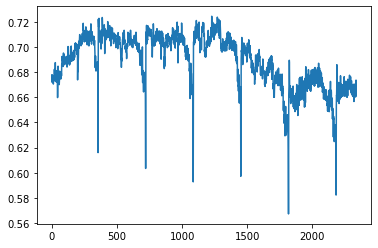

In [5]:
plt.plot(Mean_dance)

In [64]:
filtered_df = dailymean_df.loc[dailymean_df['Mean_dance'] < 0.62]

In [65]:
filtered_df
# Christmas!!

,Date,Mean_dance,Mean_energy,Mean_loud,Mean_speech,Mean_acoustic,Mean_instru,Mean_valence
355,2017-12-26,0.615981,0.547325,-7754.633495,0.077796,0.394772,0.003194,0.550694
719,2018-12-25,0.614697,0.550875,-7182.036250,0.079303,0.403582,0.009832,0.527769
720,2018-12-26,0.603402,0.538703,-7519.199091,0.079541,0.429057,0.009928,0.528450
1084,2019-12-25,0.608851,0.541817,-7151.091827,0.072236,0.405207,0.006048,0.551024
1085,2019-12-26,0.592742,0.527809,-7603.234450,0.071282,0.428459,0.006100,0.546033
1450,2020-12-25,0.597177,0.538254,-7423.150048,0.074512,0.425703,0.003220,0.578751
1451,2020-12-26,0.598651,0.529077,-7683.675263,0.075153,0.427368,0.003053,0.574569
1814,2021-12-24,0.618362,0.598668,-6348.762613,0.069724,0.364452,0.007367,0.559417
1815,2021-12-25,0.583307,0.564915,-7123.417236,0.063070,0.413085,0.003402,0.567925
1816,2021-12-26,0.567271,0.560980,-7361.093518,0.063824,0.435161,0.008075,0.567945


In [6]:
# Holt-Winters
Dance_daily = { 'Mean_dance':Mean_dance}
Dancedaily_df = pd.DataFrame(data=Mean_dance)

In [7]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize   
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
                        

class HoltWinters:# Optimized MA Model
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
 
    def initial_trend(self):
        """
        
        initial_trend,using the data in the first period 
        :return: initial_trend
        """
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen
 
    def initial_seasonal_components(self):
        """
        initial_seasonal_components
        :return: Season effects on periodic averages
        """
        seasonals = {}
        season_averages = []
        # Number of season
        n_seasons = int(len(self.series) / self.slen)
        # season averages
        for j in range(n_seasons):
            season_averages.append(np.mean(self.series[self.slen * j:self.slen * j + self.slen]))
        # nitial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals
 
    def triple_exponential_smoothing(self):
        """
        triple_exponential_smoothing
        :return:
        """
        # Prediction
        self.result = []
        # Smoothing
        self.Smooth = []
        # Season
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        seasonals = self.initial_seasonal_components()
 
        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
 
                self.PredictedDeviation.append(0)
 
                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
 
                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                continue
 
            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])
                # self.result.append(max(0,min(1, (smooth + m * trend) + seasonals[i % self.slen])))
 
                # increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
 
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (
                        smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                # self.result.append(max(0,min(1, smooth + trend + seasonals[i % self.slen])))
 
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1 - self.gamma) * self.PredictedDeviation[-1])
 
            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])
 
            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])
 
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])
 
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=7):
    """
        Returns error on CV
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
 
    values = series.values
    alpha, beta, gamma = params
 
    # set the number of folds for cross-validation
    # tscv = TimeSeriesSplit(n_splits=50, test_size=4)
    tscv = TimeSeriesSplit(n_splits=10)
 
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):
        model = HoltWinters(series=values[train], slen=slen,
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
 
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
 
    return np.mean(np.array(errors))  # mean errors


In [8]:
if __name__ == '__main__':
    data = Dancedaily_df
    # initializing model parameters alpha, beta and gamma
    cycle = 7
    pre_len = 30
    Train_test_data=data.iloc[1822:2306-60].reset_index(drop=True)#2022..1.1-2023.3.29
    Validate_data=data.iloc[2306-60:2306].reset_index(drop=True)#2023.3.30-2023.4.28 
    Result_data=data.iloc[2306-60:].reset_index(drop=True)#2023.3.30-2023.5.29 the data from model.result contains 30 days of pure prediction
    # Minimizing the loss function
    opt = minimize(timeseriesCVscore, x0=[0, 0, 0],
                args=(Train_test_data, mean_squared_error,),
                method='Nelder-Mead'  , bounds=((0, 1), (0, 1), (0, 1))
                )
    print('Finished opt!')
    # Take optimal values...
    alpha, beta, gamma = opt.x
    print(opt.fun)
    model = HoltWinters(Validate_data[0], slen=cycle,
                        alpha=alpha,
                        beta=beta,
                        gamma=gamma,
                        n_preds=pre_len, scaling_factor=2)
    print('Finished model!')
    model.triple_exponential_smoothing()
    #'Nelder-Mead':0.004047127043766115 Good! 0.0000051 0.0000152
     #'Nelder-Mead' with 6 folds: 0.0026186684065304493 Good! 0.0000051 0.0000152
    #'L-BFGS-B': 0.0006596200731843452 Good! 0.000006
    #'CG': 0.0004136189785127483 Good! 0.000006
    #'Powell': 0.0008448604549845748 Not as good 0.00001
    #'trust-constr':0.0006010416317593148 Not as good 0.000005
    #'COBYLA' :0.00042636367356643963 Not as good 0.000008
    #'SLSQP':0.00043942046646299046 Bad! 0.000019
    #'TNC': 0.00036063312123996047 Bad! 0.000023

Finished opt!
0.0012347481030937863
Finished model!


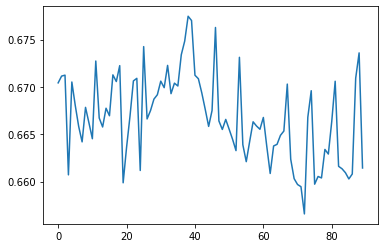

In [9]:
plt.plot(Result_data)

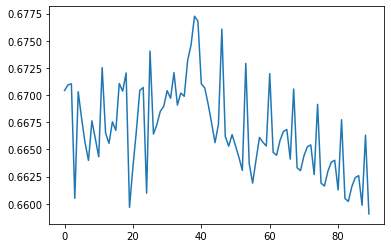

In [10]:
plt.plot(model.result)

In [146]:
"%.7f" %((Result_data[60:]-pd.DataFrame(model.result)[60:]).pow(2).mean()/((Result_data[60:]).pow(2).mean()))#NMSE

'0.0000346'

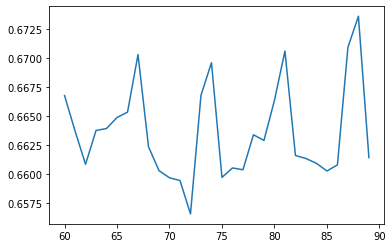

In [12]:
plt.plot(Result_data[60:]) #  the 30 days of pure prediction 

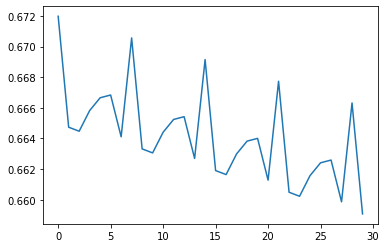

In [145]:
plt.plot(model.result[60:])

The algorithm has a good fitting to the data, and can show the trend and periodic features which can be applied to predictions in a large scale(It's actually impossible to predict the future)